In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
"""from keras.models import Sequential
from keras.layers import Dense"""

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential

import matplotlib.patches as mpatches
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy
import keras as K
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils.vis_utils import plot_model
import os

Using TensorFlow backend.


In [42]:
REL_FEATURES = [' _dewptm_bars', ' _fog', ' _hail', ' _hum_bars', ' _pressurem_bars', ' _rain', ' _snow',
                ' _thunder', ' _tornado', ' _vism_bars', ' _wspdm_bars', 'night', 'morning',
                'noon', 'evening', 'month_cos', 'month_sin', 'week_cos', 'week_sin']
LABEL = ['Temp']

# Time Series Forecast using LSTM

In [47]:
def df_train_test(model_name):
    df_train = pd.read_csv(f'../weather_data/df_{model_name}_train.csv')
    df_test = pd.read_csv(f'../weather_data/df_{model_name}_test.csv')
    return df_train, df_test

def df_train_test_hmm(model_name, test_on):
    df_train = pd.read_csv(f'../weather_data/df_full_{model_name}_train.csv')
    df_test = pd.read_csv(f'../output_from_HMM/HMM_df_{test_on}_merge_{model_name}_test.csv')
    return df_train, df_test

In [48]:
def main_func(model_name, test_on='test', rel_features=REL_FEATURES, label=LABEL, timestep=28):
    if test_on == 'test':
        df_train, df_test = df_train_test(model_name)
    else:
        df_train, df_test = df_train_test_hmm(model_name, test_on)
        
    
    df_train.set_index('datetime', inplace= True)
    df_test.set_index('datetime', inplace= True)

    X_train = df_train[rel_features].values.astype('float32')
    X_test = df_test[rel_features].values.astype('float32')

    Y_train = df_train[label].values.astype('float32')
    Y_test = df_test[label].values.astype('float32')

    for j, df in enumerate([[X_train, Y_train], [X_test, Y_test]]):
        x, y = df
        X = []
        Y = []

        for i in range(len(x)- (timestep)):
            X.append(x[i:i+timestep])
            Y.append(y[i:i+timestep])

        X = np.asanyarray(X)
        Y = np.asanyarray(Y)

        if j == 0:
            X_train = X
            Y_train = Y
        else:
            X_test = X
            Y_test = Y

    #the model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(timestep, len(REL_FEATURES))))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='mse', optimizer='adam', metrics=[accuracy_per_obs])
    history = model.fit(X_train,Y_train, epochs=100, verbose=0, validation_data=(X_test, Y_test) )

    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)

    preds_train = np.round(preds_train)
    preds_test = np.round(preds_test)

    mse_train = mean_squared_error(Y_train.ravel(), preds_train.ravel())
    mse_test = mean_squared_error(Y_test.ravel(), preds_test.ravel())
    
#     if group_id == 0 or \
    
#     if ('full' not in self.model_name and 'winter' not in self.model_name and
#          last_group['year'] != curr_group['year']) or \
#        ('winter' in self.model_name and curr_group['month'] != '1'):

#     Y_train = [item for seq in Y_train for item in seq[]]
#     preds_train
#     Y_test
#     preds_test
    acc_train = accuracy_score(Y_train.ravel(), preds_train.ravel())
    acc_test = accuracy_score(Y_test.ravel(), preds_test.ravel())

    print(f'MSE train: {mse_train}')
    print(f'MSE test: {mse_test}')

    print(f'Accuracy train: {acc_train}')
    print(f'Accuracy test: {acc_test}')

    """plt.figure(figsize=(25,10))
    plt.plot(Y_test.ravel(), 'blue', linewidth=0.1)
    plt.plot(preds_test.ravel(),'r' , linewidth=0.1)
    plt.legend(('Test','Predicted'))
    plt.show()"""

    try:
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'model {model_name} loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(f'{model_name}_loss.png')
        plt.close()
    except:
        pass

    return mse_train, mse_test, acc_train, acc_test

    """# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()"""

<a id="1"></a> <br>
# **CNN-LSTM Model**

In [49]:
data = {}

for freq_range in [[str(i) for i in range(1, 13)],  # month
                    ['autumn', 'winter', 'spring', 'monsoon', 'summer'],  # season
                    ['full']]:  # full year
    # all day
    for freq_part in freq_range:
        for day_part in ['all', 'night', 'morning', 'noon', 'evening']:
            model_name = '_'.join([freq_part, day_part])
            print(model_name)
            if day_part != 'all':
                mse_train, mse_test, acc_train, acc_test = main_func(model_name, timestep=7)
            else:
                mse_train, mse_test, acc_train, acc_test = main_func(model_name)
            data[model_name] = [mse_train, mse_test, acc_train, acc_test]

df = pd.DataFrame.from_dict(data, orient='index', columns=['mse_train', 'mse_test', 'acc_train', 'acc_test'])
df.to_csv(r'results.csv', index = True)

1_all


TypeError: The added layer must be an instance of class Layer. Found: <keras.layers.recurrent.LSTM object at 0x7fa450590080>

## Analyze results

In [19]:

df = pd.read_csv(r'res/results.csv', index_col=0)
# df['freq'] = ''
# df['day_part'] = ''

for model_name, model_row in df.iterrows():
#     print('\t', (model_name))

    if 'full' in str(model_name):
#         print('full_year')
        df.loc[model_name, 'freq'] = 'full_year'
    elif any(season in str(model_name) for season in ['winter', 'spring', 'summer', 'monsoon', 'autumn']):
#         print('season')
        df.loc[model_name, 'freq'] = 'season'
    elif any(str(month) in str(model_name) for month in range(1,13)):
#         print('month')
        df.loc[model_name, 'freq'] = 'month'
    else:
        raise 'error'
    if 'all' in str(model_name):
#         print('all_day')
        df.loc[model_name, 'day_part'] = 'all_day'
    elif any(season in str(model_name) for season in ['night', 'morning', 'noon', 'evening']):
#         print('day_part')
        df.loc[model_name, 'day_part'] = 'one_part'
    else:
        raise 'error'

df

,mse_train,mse_test,acc_train,acc_test,freq,day_part
1_all,0.083531,0.242560,0.917181,0.757440,month,all_day
1_night,0.202460,0.226190,0.804636,0.773810,month,one_part
1_morning,0.451827,0.613095,0.600854,0.529762,month,one_part
1_noon,0.480476,0.392857,0.575714,0.678571,month,one_part
1_evening,0.261509,0.273810,0.745610,0.726190,month,one_part
2_all,0.238787,0.230442,0.767037,0.770833,month,all_day
2_night,0.363250,0.244898,0.674456,0.755102,month,one_part
2_morning,0.679377,0.530612,0.517186,0.510204,month,one_part
2_noon,0.593985,0.489796,0.545650,0.571429,month,one_part
2_evening,0.385070,0.387755,0.655209,0.693878,month,one_part


In [23]:
df.groupby(['freq', 'day_part'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()

mse_test  acc_test  mse_train  acc_train
freq      day_part                                          
full_year all_day   0.269527  0.745346   0.033941   0.966838
          one_part  0.233935  0.772100   0.196257   0.808700
month     all_day   0.378797  0.658425   0.239284   0.771400
          one_part  0.621585  0.532644   0.554737   0.571292
season    all_day   0.287857  0.747914   0.110669   0.891125
          one_part  0.381384  0.657250   0.356697   0.681198

/Users/MosheAbadi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/MosheAbadi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/MosheAbadi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/MosheAbadi/anaconda3/lib/python3.7/site-packages/pan

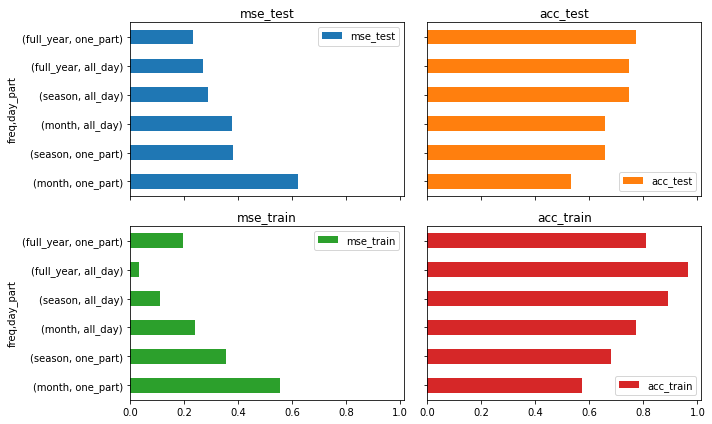

In [22]:
df.groupby(['freq', 'day_part'])[['mse_test', 'acc_test', 'mse_train', 'acc_train']].mean()\
  .sort_values('mse_test', ascending=False)\
  .plot.barh(y=['mse_test', 'acc_test', 'mse_train', 'acc_train'], 
              subplots=True, layout=(2, 2), sharey=True, figsize=(10, 6))
plt.tight_layout()
plt.savefig('model_cmp.png')

,mse_train,mse_test,acc_train,acc_test,freq,day_part
1_all,0.083531,0.242560,0.917181,0.757440,month,NaN
1_night,0.202460,0.226190,0.804636,0.773810,NaN,NaN
1_morning,0.451827,0.613095,0.600854,0.529762,NaN,NaN
1_noon,0.480476,0.392857,0.575714,0.678571,NaN,NaN
1_evening,0.261509,0.273810,0.745610,0.726190,NaN,NaN
2_all,0.238787,0.230442,0.767037,0.770833,NaN,NaN
2_night,0.363250,0.244898,0.674456,0.755102,NaN,NaN
2_morning,0.679377,0.530612,0.517186,0.510204,NaN,NaN
2_noon,0.593985,0.489796,0.545650,0.571429,NaN,NaN
2_evening,0.385070,0.387755,0.655209,0.693878,NaN,NaN


In [70]:
def accuracy_per_obs(y_true, y_pred):
    print(np.add(y_true, 0))
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    """y_true = tf.reshape(y_true, [len(y_true)])
    y_pred = tf.reshape(y_pred, [len(y_true)])
    return Accuracy().update_state(y_true, y_pred)"""
    #return accuracy_score(y_true, y_pred)
    return Accuracy(y_true, y_pred)

In [71]:
"""#too complicated
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(len(REL_FEATURES),1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(128, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train,Y_train,epochs=50, verbose=0 )"""

"#too complicated\nmodel = Sequential()\nmodel.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(len(REL_FEATURES),1)))\nmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu'))\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Flatten())\nmodel.add(RepeatVector(30))\nmodel.add(LSTM(128, activation='relu'))\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(1))\nmodel.compile(loss='mse', optimizer='adam')\nmodel.fit(X_train,Y_train,epochs=50, verbose=0 )"

In [45]:
for model_name in ['night', 'morning', 'noon', 'evening']:
    for test_on in ['season', 'months']:
        main_func(model_name, test_on=test_on, timestep=7)

TypeError: The added layer must be an instance of class Layer. Found: <keras.layers.recurrent.LSTM object at 0x7fa44fe7b128>